In [1]:
from echopype.convert import Convert
from echopype import Process
import glob
import random
import matplotlib.pyplot as plt

import numpy as np


from glider_azfp import load_glider, merge_glider_AZFP

In [2]:
gl = load_glider(dataset_id ='ru32-20190102T1317-profile-sci-rt')

gl

<xarray.Dataset>
Dimensions:                  (profile: 712, time: 113708)
Coordinates:
  * time                     (time) datetime64[ns] 2019-01-02T13:28:23.977110...
    latitude                 (time) float64 ...
    longitude                (time) float64 ...
    depth                    (time) float32 ...
Dimensions without coordinates: profile
Data variables:
    profile_id               (profile) float64 ...
    rowSize                  (profile) int32 ...
    trajectory               (time) object ...
    source_file              (time) object ...
    backscatter_coefficient  (time) float32 ...
    cdom                     (time) float32 ...
    chlorophyll_a            (time) float32 ...
    conductivity             (time) float32 ...
    crs                      (time) float64 ...
    ctd41cp_timestamp        (time) datetime64[ns] ...
    density                  (time) float32 ...
    flbbcd_timestamp         (time) datetime64[ns] ...
    instrument_azfp          (time) float64 ...
    instrument_ctd           (time) float64 ...
    instrument_flbbcd        (time) float64 ...
    m_pitch                  (time) float32 ...
    m_roll                   (time) float32 ...
    platform                 (time) float64 ...
    potential_temperature    (time) float32 ...
    pressure                 (time) float32 ...
    profile_lat              (time) float64 ...
    profile_lon              (time) float64 ...
    profile_time             (time) datetime64[ns] ...
    salinity                 (time) float32 ...
    sci_azfp_file_offset     (time) float32 ...
    sci_azfp_pause_signal    (time) float32 ...
    sci_azfp_run_state       (time) float32 ...
    sci_m_disk_free          (time) float32 ...
    sci_m_present_time       (time) datetime64[ns] ...
    sci_water_pressure       (time) float32 ...
    sound_speed              (time) float32 ...
    temperature              (time) float32 ...
    bottom_depth             (time) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    cdm_data_type:                   Profile
    cdm_profile_variables:           profile_id
    comment:                         Deployed by Schuyler Nardelli and Nicole...
    contributor_name:                Oscar Schofield,Deborah Steinberg,Schuyl...
    contributor_role:                Principal Investigator,Principal Investi...
    Conventions:                     CF-1.6, COARDS, ACDD-1.3
    creator_email:                   kerfoot@marine.rutgers.edu
    creator_institution:             Rutgers University
    creator_name:                    John Kerfoot
    creator_type:                    person
    creator_url:                     https://rucool.marine.rutgers.edu
    date_created:                    2019-02-11T16:31:58Z
    date_issued:                     2019-02-11T16:31:58Z
    date_modified:                   2019-02-11T16:31:58Z
    defaultGraphQuery:               temperature,depth,time&time>=max(time)-1...
    deployment_id:                   555
    deployment_name:                 ru32-20190102T1317
    Easternmost_Easting:             -64.00858744126144
    featureType:                     Profile
    geospatial_bounds:               POLYGON ((-64.86942438308976 -64.0560274...
    geospatial_bounds_crs:           EPSG:4326
    geospatial_bounds_vertical_crs:  EPSG:5831
    geospatial_lat_max:              -64.80610558179691
    geospatial_lat_min:              -64.8726387254351
    geospatial_lat_resolution:       0.00001 degree
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              -64.00858744126144
    geospatial_lon_min:              -64.18408172522112
    geospatial_lon_resolution:       0.00001 degree
    geospatial_lon_units:            degrees_east
    geospatial_verical_resolution:   1
    geospatial_vertical_max:         595.7142
    geospatial_vertical_min:         0.009902111
    geospatial_vertical_positive:    down
    geospatial_vertical_units:       m
    history:       

# load an AZFP file

you'd want to build the loop below here

In [24]:
path_to_raw = './data/'

# alternativly, pick a random file
all_files = glob.glob(path_to_raw+'*.01A')
# a random file from the list (got to remove path and extention)
fname = random.choice(all_files)[7:-4]

# path to the 'fake' calibration file
calib_file = './data/NLB_test.XML'

print('random file used:')
print(fname + '.01A')

random file used:
19011713.01A


In [25]:

# fname = '19011711'

# converts the raw AZFP data
# we are 'tricking' echopype with a fake .XML file
# the real files fail because there is no temperature data
# edit the './data/' parts so the path works for where you put the files
data_tmp = Convert(path_to_raw + fname + '.01A', calib_file)


# place to save processed files
savedir = './data_netcdfs/'

# converts to a netcdf we can use with xarray
data_tmp.raw2nc(save_path = savedir )


# read the converted data 

nc_path = savedir + fname + '.nc'

# process so you can get calibrated, clean, data 

ed = Process(nc_path)   # create a processing object

# need to figure out how much it matter that these vary a lot

ed.temperature = gl.potential_temperature.mean().values  
ed.salinity = gl.salinity.mean().values     
ed.pressure = gl.pressure.mean().values     # pressure in dbar
ed.recalculate_environment()  # recalculate related parameters

ed.calibrate()           # Sv
ed.remove_noise()        # denoise, this is adaptive! will change with the file!

azfp = ed.Sv_clean


12:18:08 converting file 19011713.01A with NLB_test.XML, time of first ping 2019-Jan-17 13:54:40
          ... this file has already been converted to .nc, conversion not executed.
Initialize using average temperature recorded by instrument
12:18:08  calibrating data in ./data_netcdfs/19011713.nc
12:18:08  Remove noise from Sv stored in memory.


In [26]:
ds = merge_glider_AZFP( gl, azfp, )

ds

<xarray.Dataset>
Dimensions:                   (frequency: 3, ping_time: 107, range_bin: 1999)
Coordinates:
  * frequency                 (frequency) int64 38000 125000 200000
  * ping_time                 (ping_time) datetime64[ns] 2019-01-17T13:54:40 ...
  * range_bin                 (range_bin) int64 0 1 2 3 ... 1995 1996 1997 1998
    bin_depths                (ping_time, range_bin) float64 4.103 ... 105.6
Data variables:
    Sv                        (frequency, ping_time, range_bin) float64 -115....
    noise_est_range_bin_size  (frequency, ping_time) float64 5.017 ... 5.017
    range                     (frequency, range_bin, ping_time) float64 0.363...
    potential_temperature     (ping_time) float64 1.093 1.093 ... 0.1043 0.1272
    salinity                  (ping_time) float64 33.12 33.12 ... 33.89 33.9
    chlorophyll_a             (ping_time) float64 1.139 1.138 ... 0.7446 0.7119
    m_pitch                   (ping_time) float64 -0.2659 -0.2678 ... -0.4177
    m_roll                    (ping_time) float64 -0.03519 -0.0352 ... -0.03617
    bottom_depth              (ping_time) float64 381.5 381.5 ... 382.5 382.5
    latitude                  (ping_time) float64 -64.86 -64.86 ... -64.86
    longitude                 (ping_time) float64 -64.01 -64.01 ... -64.01
    depth                     (ping_time) float64 3.74 3.739 ... 32.18 32.6

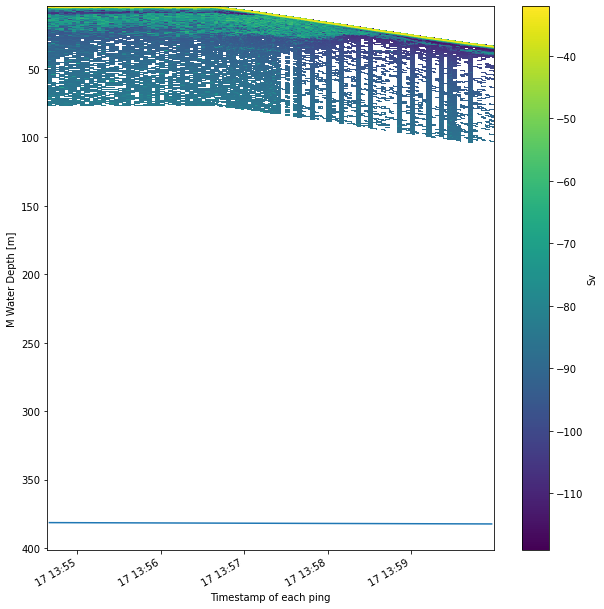

In [23]:

plt.figure(figsize=(10,10))
ds.Sv[0,:,:].plot(x="ping_time", y="bin_depths", yincrease=False)
ds.bottom_depth.plot()
